In [ ]:
!pip install docplex
!pip install cplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import time
import docplex.mp.model as md
import networkx as nx
import matplotlib.pyplot as plt
import random
from random import randint
from scipy.spatial import Delaunay
from itertools import permutations

In [ ]:
def initialize_triangles(edges):
  # t means triangle edges here
  t=[]
  for i in range(nodes):
    for j in range(i,nodes):
      for k in range(j,nodes):
        if i!=j!=k:
          t.append(((i,j),(j,k),(i,k)))
        else:
          continue
  return t

def triangles(edges,l):
  t=initialize_triangles(edges)
  # find triangles with edge l
  contain_l=[]
  for i in range(len(t)):
    if edges[l] in t[i]:
      contain_l.append(t[i])
    else:
      continue
  reproduce_edges_with_l=[]
  for i in range(len(contain_l)):
    for j in range(3):
        reproduce_edges_with_l.append(contain_l[i][j])
  return reproduce_edges_with_l

Note I could not access this paper, but there is a paper on the QUBO for this problem: https://www.tandfonline.com/doi/abs/10.1080/02522667.2021.1930657?journalCode=tios20

**Monochromatic Triangle Problem (NP-Complete problem)**

**Goal:** Partition edges of a graph into two triangle free subgraphs.

**Important condition(Ramsey's theorem):** For $k$ colors, there exists a complete graph $K_n$ with a number of $n = k(k+1)$ or more vertices such that no solution exists. For the case of two colors $k=2$, $n=2(2+1) = 6$, our graph must have less than $6$ vertices to admit a solution.



In this complete graph $K_n$ with $n$ nodes, there are $E = \frac{n(n-1)}{2}$ edges. There are $k$ colors. Place a qubit $x_{ij}$ on each edge $i$ with color $j$. 

Note: There are ${n \choose 3}$ distinct triangles in this graph, and each edge is a part of $n-2$ triangles.

$$H = A\underbrace{\sum_{i=1}^E \left( \sum_{j=1}^k x_{ij} -1 \right)^2}_{\text{every edge $i$  gets assigned one color $j$}}  + B \underbrace{\sum_{j=1}^k \left[  \sum_{\substack{\text{Triangles with} \\ \text{edges $m,n,p$}}} x_{mj}+x_{nj}+x_{pj} \right]^2}_{\text{each triangle minimizes the total edges with color $j$}}$$



In [ ]:
nodes, colors, A, B = 6, 3, 1000, 10
# number of edges with n nodes
e=int(nodes*(nodes-1)/2)
# Create Nodes
np.random.seed(50)
x_coord = np.random.randint(0,100,nodes)
np.random.seed(1)
y_coord = np.random.randint(0,100,nodes)
points=[]
for i in range(nodes):
    points.append((x_coord[i],y_coord[i]))

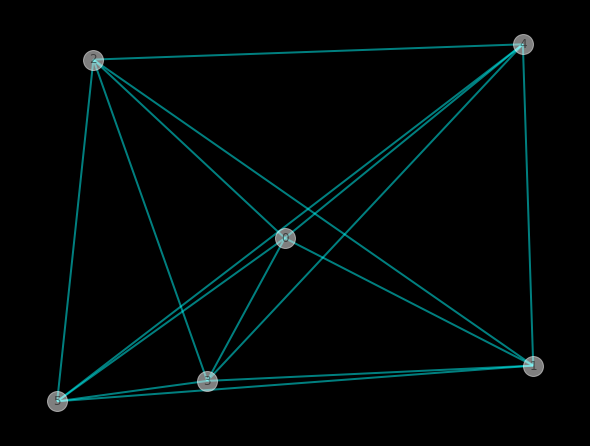

In [ ]:
# Generate Graph With Nodes and Edges
G = nx.Graph()
for i in range(nodes): 
    G.add_node(i,pos=points[i])
edges=[]
for i in range(nodes):
  for j in range(i,nodes):
    if i!=j and (j,i) not in edges:
      edges.append((i,j))
    else:
      continue
G.add_edges_from(edges)
fig = plt.figure(figsize=(8, 6))
nx.draw(G, pos=nx.get_node_attributes(G,'pos'), with_labels=True, alpha=0.5, node_color='w', edge_color='cyan',width=2.0,node_size=400)
fig.set_facecolor("#000000")

In [ ]:
color=md.Model(name='Monochromatic_Triangle')
x=np.array(color.binary_var_list(e*colors)).reshape(e,colors)
H1 = A*np.sum([ [ (np.sum(x[i,:])-1)**2 ] for i in range(e)])
H2 = B*np.sum([ [ (x[edges.index(i[0])][j]+x[edges.index(i[1])][j]+x[edges.index(i[2])][j])**2 ]  for j in range(colors) for i in initialize_triangles(edges) ])
color.minimize(H1+H2)
solution = np.array(color.solve().get_value_list(x.flatten())).reshape(e,colors)
print(solution)

[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


[(0, 1, {'color': '#C636A8'}), (0, 2, {'color': '#B7E146'}), (0, 3, {'color': '#B7E146'}), (0, 4, {'color': '#C636A8'}), (0, 5, {'color': '#047CC8'}), (1, 2, {'color': '#B7E146'}), (1, 3, {'color': '#047CC8'}), (1, 4, {'color': '#047CC8'}), (1, 5, {'color': '#B7E146'}), (2, 3, {'color': '#047CC8'}), (2, 4, {'color': '#C636A8'}), (2, 5, {'color': '#C636A8'}), (3, 4, {'color': '#B7E146'}), (3, 5, {'color': '#C636A8'}), (4, 5, {'color': '#047CC8'})]


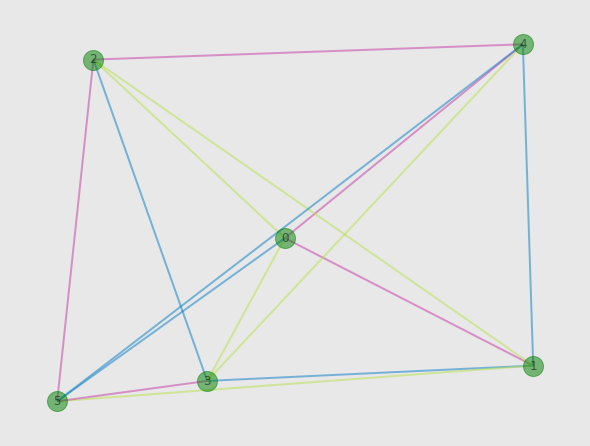

In [ ]:
# Plot Solution
# Generate Graph With Nodes and Edges
G2_d = nx.Graph()
c = []
for i in range(colors):
  c.append('#%06X' % randint(0, 0xFFFFFF))
for i in range(nodes): 
    G2_d.add_node(i,pos=points[i])
for i in range(e): 
  for j in range(colors):
    if solution[i,j]==1:
        G2_d.add_edge(edges[i][0],edges[i][1],color=c[j])
print(G2_d.edges(data=True))
colors = [ edge[2]['color'] for edge in G2_d.edges(data=True)]
fig2 = plt.figure(figsize=(8, 6))
nx.draw(G2_d, pos=nx.get_node_attributes(G2_d,'pos'), with_labels=True, edge_color=colors, node_color = 'g', width=2.0,alpha=0.5, node_size=400)
fig2.set_facecolor("#E8E8E8")